#**Taller Práctico 4 – Detección y Segmentación con YOLO + SAM**
### **Objetivo:** Integrar YOLOv8 para detección de objetos y SAM para segmentación de instancias, aplicando análisis visual como pixelado del fondo.

## --- Instalación de dependencias ---

In [21]:
!pip install ultralytics
!pip install git+https://github.com/facebookresearch/segment-anything.git
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-cwkrbk_9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-cwkrbk_9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2025-06-14 16:38:00--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.176.115, 18.238.176.126, 18.238.176.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.6’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  76.2MB/s    in 39s     

2025-06-14 16:38:39 (63.2 MB/s) - ‘sam_vit_h_4b8939.pth.6’ saved [2564550879/2564550879

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from segment_anything import SamPredictor, sam_model_registry
import os
from uuid import uuid4

# Crear directorios para outputs
os.makedirs('outputs/recortes', exist_ok=True)
os.makedirs('outputs/segmentaciones', exist_ok=True)

## --- Función 1: Detección de objetos con YOLO ---

In [23]:
def detectar_objetos_yolo(imagen_path):
    """
    Detecta objetos en una imagen usando YOLOv8.
    Retorna las coordenadas de las cajas delimitadoras y las clases.
    """
    model = YOLO('yolov8n.pt')  # Cargar modelo YOLOv8 preentrenado
    results = model(imagen_path)

    boxes = []
    classes = []
    for result in results:
        for box in result.boxes:
            # Coordenadas: [x_min, y_min, x_max, y_max]
            boxes.append(box.xyxy[0].cpu().numpy().astype(int))
            classes.append(result.names[int(box.cls)])

    return boxes, classes, results[0].orig_img


## --- Función 2: Segmentación con SAM ---

In [24]:
def segmentar_con_sam(imagen, boxes):
    """
    Segmenta objetos usando SAM con las cajas de YOLO como prompts.
    Retorna una lista de máscaras.
    """
    sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
    predictor = SamPredictor(sam)
    predictor.set_image(imagen)

    masks = []
    for box in boxes:
        mask, _, _ = predictor.predict(box=box, point_labels=np.array([1]), multimask_output=False) # Changed box_coordinates to box and box_labels to point_labels
        masks.append(mask[0])

    return masks


## --- Función 3: Visualización de resultados ---

In [25]:
def visualizar_deteccion_segmentacion(imagen, boxes, masks, classes):
    """
    Visualiza la imagen original con cajas y máscaras, y guarda recortes.
    """
    # Copia de la imagen para superponer resultados
    img_with_boxes = imagen.copy()
    img_with_masks = imagen.copy()

    for i, (box, mask, cls) in enumerate(zip(boxes, masks, classes)):
        # Dibujar caja delimitadora
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(img_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(img_with_boxes, cls, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Superponer máscara
        mask_color = np.zeros_like(imagen)
        mask_color[mask] = [0, 255, 255]  # Color cian para la máscara
        img_with_masks = cv2.addWeighted(img_with_masks, 1, mask_color, 0.5, 0)

        # Guardar recorte con fondo blanco
        mask_3ch = np.stack([mask]*3, axis=-1)
        cropped = np.where(mask_3ch, imagen, 255)
        cropped = cropped[y_min:y_max, x_min:x_max]
        cv2.imwrite(f'outputs/recortes/{cls}_{str(uuid4())[:8]}.png', cropped)

        # Guardar máscara individual
        cv2.imwrite(f'outputs/segmentaciones/mask_{cls}_{str(uuid4())[:8]}.png', mask.astype(np.uint8) * 255)

    # Guardar imagen con resultados combinados
    cv2.imwrite('outputs/resultados.png', cv2.cvtColor(img_with_boxes, cv2.COLOR_RGB2BGR))

    # Mostrar resultados
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title("Cajas Delimitadoras")
    plt.imshow(img_with_boxes)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Máscaras Segmentadas")
    plt.imshow(img_with_masks)
    plt.axis('off')
    plt.show()


## --- Función 4: Análisis creativo (pixelado del fondo) ---

In [26]:
def analizar_segmentaciones(imagen, masks, boxes, classes):
    """
    Aplica pixelado al fondo, manteniendo las regiones segmentadas intactas y
    retorna los datos de los objetos detectados y segmentados.
    """
    img_pixelated = cv2.GaussianBlur(imagen, (21, 21), 0)  # Aplicar desenfoque
    combined_mask = np.zeros_like(imagen[:, :, 0], dtype=bool)

    datos = []
    conteo_clases = defaultdict(int)
    h, w = imagen.shape[:2]
    total_area = h * w

    for i, (mask, box, cls) in enumerate(zip(masks, boxes, classes)):
        combined_mask |= mask

        # Calcular área en píxeles y porcentaje
        area = np.sum(mask)
        x_min, y_min, x_max, y_max = box
        conteo_clases[cls] += 1
        porcentaje = round((area / total_area) * 100, 2)

        # Guardar datos
        datos.append({
            "objeto_id": i,
            "clase": cls,
            "x1": x_min, "y1": y_min, "x2": x_max, "y2": y_max,
            "area_pixeles": int(area),
            "area_%": porcentaje
        })


    # Mantener regiones segmentadas sin pixelar
    result = np.where(np.stack([combined_mask]*3, axis=-1), imagen, img_pixelated)

    # Guardar resultado
    cv2.imwrite('outputs/pixelado_fondo.png', cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

    # Mostrar resultado
    plt.figure(figsize=(8, 8))
    plt.title("Fondo Pixelado")
    plt.imshow(result)
    plt.axis('off')
    plt.show()

    return pd.DataFrame(datos), conteo_clases

from collections import defaultdict
import pandas as pd

## --- Ejecución del pipeline ---


image 1/1 /content/images/ejemplo1.jpg: 640x640 1 cat, 1 dog, 213.7ms
Speed: 4.0ms preprocess, 213.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


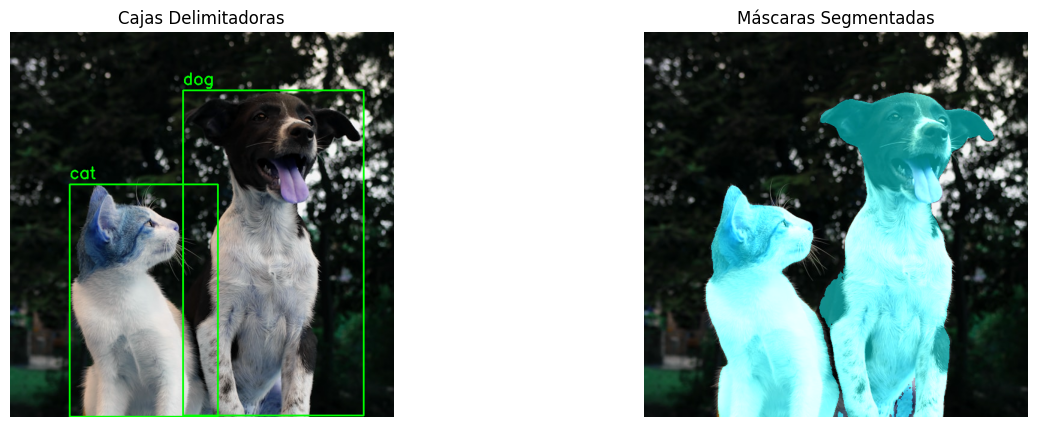

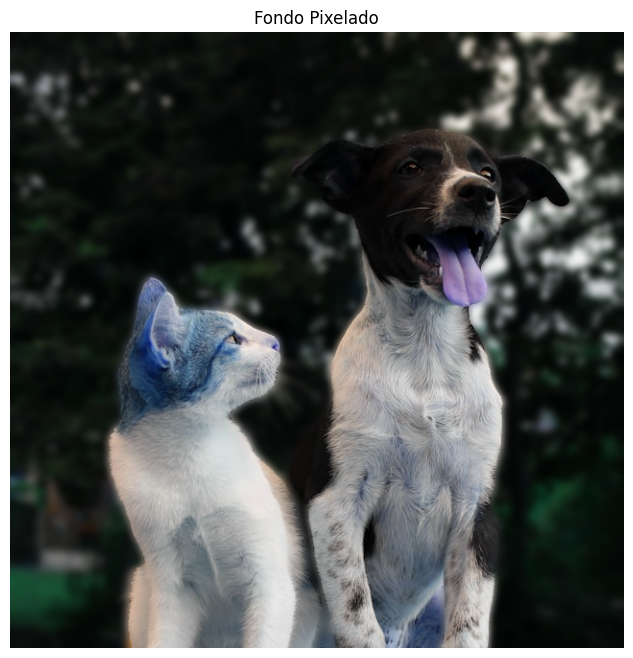

Conteo por clase:
- dog: 1 objeto(s)
- cat: 1 objeto(s)


,objeto_id,clase,x1,y1,x2,y2,area_pixeles,area_%
0,0,dog,288,97,589,640,94593,22.99
1,1,cat,99,254,346,642,59457,14.45


In [27]:
def main():
    # Cargar imagen de ejemplo (reemplazar con tu propia imagen)
    imagen_path = 'images/ejemplo1.jpg'

    # Paso 1: Detección con YOLO
    boxes, classes, imagen = detectar_objetos_yolo(imagen_path)

    # Paso 2: Segmentación con SAM
    masks = segmentar_con_sam(imagen, boxes)

    # Paso 3: Visualización
    visualizar_deteccion_segmentacion(imagen, boxes, masks, classes)

    # Paso 4: Análisis (pixelado del fondo) y obtención de datos
    datos_objetos, conteo_clases = analizar_segmentaciones(imagen, masks, boxes, classes)

    # Mostrar conteo por clase
    print("Conteo por clase:")
    for clase, count in conteo_clases.items():
        print(f"- {clase}: {count} objeto(s)")

    # Mostrar tabla de datos
    display(datos_objetos)

if __name__ == "__main__":
    main()